This notebook will produce plots for use in the presentation and report.

# Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import sklearn
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from py.classifiers import classify

# Load data

In [2]:
data = pd.read_csv('./data/mbti_1.csv')
docs = list(data['posts'])
personality_types = pd.unique(data['type'])

data = data.replace({ptype: i for i, ptype in enumerate(personality_types)})
y = data['type'].values

# Classifier comparison

In [3]:
method_kwargs_list = [
    ('knn', dict(n_neighbors=100)),
    ('neural_network', dict()),
    ('decision_tree', dict()),
    ('svm', dict(kernel='linear')),
    ('kmeans', dict(n_clusters=16))
]
methods, kwargs = zip(*method_kwargs_list)

In [4]:
def reduce_dim(X_tr, X_te, n):
    svd = TruncatedSVD(n_components=n, n_iter=5, random_state=42)
    svd.fit(X_tr)
    return svd.transform(X_tr), svd.transform(X_te)

def compare_methods(analyzer='word', ngram_range=(1, 1), weight='raw', ndims_keep=1000):
    
    print('Initializing ...')
    if weight == 'raw':
        vec = CountVectorizer(input='content', analyzer=analyzer, ngram_range=ngram_range)
    if weight == 'tf':
        vec = TfidfVectorizer(input='content', analyzer=analyzer, ngram_range=ngram_range, use_idf=False)
    elif weight == 'tf-idf':
        vec = TfidfVectorizer(input='content', analyzer=analyzer, ngram_range=ngram_range, use_idf=True)
        
    X = vec.fit_transform(docs)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
    if ndims_keep != 'all':
        X_tr, X_te = reduce_dim(X_tr, X_te, ndims_keep)
        
    accuracies, runtimes = [], []
    for (method, kwargs) in method_kwargs_list:
        print('Running {} ...'.format(method))
        y_pred, runtime = classify(X_tr, y_tr, X_te, method, **kwargs)
        accuracy = accuracy_score(y_pred, y_te)
        accuracies.append(accuracy)
        runtimes.append(runtime)
        print('    accuracy = {:.4f}'.format(accuracy))
        print('    runtime = {:.2f} seconds'.format(runtime))
        
    return accuracies, runtimes

In [5]:
ngram_range = (1, 1)
analyzer = 'word'
ndims_keep = 1000
weight = 'tf-idf'

accuracies, runtimes = compare_methods(analyzer, ngram_range, weight, ndims_keep)

Initializing ...
Running knn ...
    accuracy = 0.4029
    runtime = 18.97 seconds
Running neural_network ...


/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


    accuracy = 0.6161
    runtime = 21.50 seconds
Running decision_tree ...
    accuracy = 0.3303
    runtime = 10.27 seconds
Running svm ...
    accuracy = 0.6138
    runtime = 85.13 seconds
Running kmeans ...
    accuracy = 0.0761
    runtime = 5.34 seconds


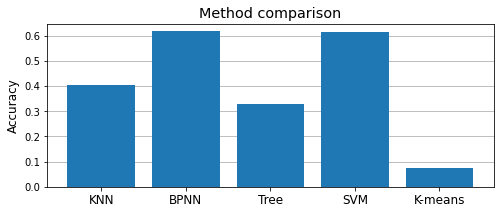

In [11]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.bar(methods, accuracies, zorder=2)
ax.grid(axis='y', zorder=0)
ax.set_xticklabels(['KNN', 'BPNN', 'Tree', 'SVM', 'K-means'], fontsize='large')
ax.set_title('Method comparison', fontsize='x-large')
ax.set_ylabel('Accuracy', fontsize='large')
plt.savefig('figures/method_comparison.png', dpi=300)

# Feature comparison

In [ ]:
ndims_keep = 5000
weight = 'tf-idf'
accuracies_list = {}
runtimes_dict = {}

for n in range(1, 7):
    if n == 1:
        analyzer == 'word'
        key = 'word'
    else:
        analyzer == 'char'
        key = 'n{}'.format(n)
    print(key)
    accuracies, runtimes = compare_methods(analyzer, (n, n), weight, ndims_keep)
    accuracies_dict[key] = accuracies
    runtimes_dict[key] = runtimes
    print()

In [ ]:
accuracies_by_method = []
keys = list(accuracies_dict.keys())

fig, ax = plt.subplots()
for i, method in enumerate(methods):
    accs_by_method = [accuracies_dict[k][i] for k in accuracies_dict.keys()]
    ax.plot(keys, accs_by_method, 'o-', label=method)
ax.legend(framealpha=1)
ax.grid(axis='x')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Feature type')
ax.set_title('Accuracy vs. feature type');

# KNN: accuracy vs $k$

In [ ]:
k_vals = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
ndims_keep = 20000
accuracies, runtimes = [], []

vec = TfidfVectorizer(input='content', analyzer=analyzer, ngram_range=ngram_range, use_idf=True)
X = vec.fit_transform(docs)
X = SelectKBest(chi2, k=ndims_keep).fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for k in tqdm(k_vals):
    y_pred, runtime = classify(X_train, y_train, X_test, 'knn', n_neighbors=k)
    accuracy = accuracy_score(y_pred, y_test)
    accuracies.append(accuracy)
    runtimes.append(runtime)

In [ ]:
fig, ax = plt.subplots()
ax.plot(k_vals, accuracies, 'o')
ax.set_ylabel('Accuracy')
ax.set_xlabel('k')
ax.set_title(r'KNN accuracy vs. $k$')